In [ ]:
from langchain.callbacks.base import BaseCallbackHandler
import re
import json
import time

class ThinkTagCallback(BaseCallbackHandler):
    def __init__(self):
        self.in_think = False  # 是否在<think>标签内
        self.think_buffer = ""  # 推理内容缓冲区
        self.answer_buffer = ""  # 答案缓冲区
        self.temp_buffer = ""   # 临时缓冲区（处理跨token的标签）
        
        # 标签匹配正则表达式
        self.tag_pattern = re.compile(r"(<think>|</think>)", re.IGNORECASE)

    def on_llm_new_token(self, token: str, **kwargs) -> None:
        self.temp_buffer += token  # 将新token添加到临时缓冲区
        
        # 切割出所有可能标签
        parts = self.tag_pattern.split(self.temp_buffer)
        self.temp_buffer = ""  # 清空临时缓冲区
        
        for part in parts:
            if not part:
                continue
                
            # 处理标签状态切换
            if part.lower() == "<think>":
                if not self.in_think:
                    self.in_think = True  # 进入<think>标签内
                continue
            elif part.lower() == "</think>":
                if self.in_think:
                    self.in_think = False
                continue
                
            # 根据状态分配内容
            if self.in_think:
                self.think_buffer += part
            else:
                self.answer_buffer += part

    def stream_data(self):
        while True:
            # 发送完整推理段落
            if self.think_buffer:
                yield f"data: {json.dumps({'type': 'reasoning', 'content': self.think_buffer})}\n\n"
                self.think_buffer = ""
                
            # 发送答案内容
            if self.answer_buffer:
                yield f"data: {json.dumps({'type': 'answer', 'content': self.answer_buffer})}\n\n"
                self.answer_buffer = ""
                
            # 结束条件（根据实际业务调整）
            if ...:  
                break
                
            time.sleep(0.1)

In [60]:
# 添加测试端点
def test_callback():
    test_callback = ThinkTagCallback()
    test_callback.on_llm_new_token("<think>Test data handler</think>final anser is none")
    return {
        "reasoning": test_callback.think_buffer,
        "answer": test_callback.answer_buffer
    }
test_callback()

{'reasoning': 'Test data handler', 'answer': 'final anser is none'}

In [55]:

import os
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama, OllamaLLM, OllamaEmbeddings
load_dotenv()
# deepseek-r1:32b ｜ qwq:32b
chat_model = ChatOllama(
    base_url=os.environ['OLLAMA_BASE_URL'],  # 可配置为内部服务器地址
    model="qwq:32b",
    temperature=0.8,
    num_ctx=4096,  # 上下文窗口大小
    # callbacks=[ReasoningAndAnswerCallback()],  # 自定义回调处理器
    streaming=True,  # 开启流式输出
    # extract_reasoning=False
)
# 2.加载模型
embedding_model = OllamaEmbeddings(
    base_url=os.environ['OLLAMA_BASE_URL'],  # 可配置为内部服务器地址
    model=os.environ['OLLAMA_EMBEDDING_MODEL_NAME'],
    temperature=0.8,
    num_ctx=4096  # 上下文窗口大小
)
llm_model = OllamaLLM(
    base_url=os.environ['OLLAMA_BASE_URL'],  # 可配置为内部服务器地址
    model="deepseek-r1:32b",
    temperature=0.2, # 控制随机性（0 确定性高，1 创造性高）。
    num_ctx=4096,  # 上下文窗口大小
    top_p=0.8, #核采样概率，过滤低概率 token（0.1 严格，1.0 宽松）。
    )

# messages = [
#     SystemMessage(content="你是一个助手，用简体中文回答。"),
#     HumanMessage(content="推荐一本关于AI的书籍。")
# ]
# response = model.invoke(messages)
# print(response.content)  # 输出结构化消息
# for chunk in model.stream(messages):
#     print(chunk.content, end="", flush=True)





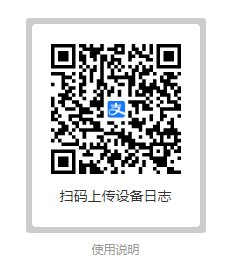

In [27]:
from langchain_core.messages import HumanMessage
import base64

def image_to_base64(image_path):
    try:
        # 打开指定路径的图像文件，以二进制读取模式("rb")
        with open(image_path, "rb") as img_file:
            # 使用base64库将图像文件内容编码为base64字符串
            return base64.b64encode(img_file.read()).decode("utf-8")
    except FileNotFoundError:
            print(f"文件 {image_path} 未找到。")
            return None

image_b64 = image_to_base64("../files/image.png")
message = HumanMessage(content=[
    {"type": "text", "text": "描述这张图片"},
    {"type": "image_url", "image_url": f"data:image/png;base64,{image_b64}"}
])
print(f"data:image/png;base64,{image_b64}")
# 需要视觉大模型识别
# response = model.invoke([message])
# print(response)

In [56]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

prompt = ChatPromptTemplate.from_template("""
    根据用户输入判断意图类别，仅返回分类标签。
    可选标签：查询信息、操作指令、闲聊、其他。
    输入：{user_input}
    分类结果：                            
    """)
chain = RunnableParallel(user_input=RunnablePassthrough()) | prompt | chat_model | StrOutputParser()
response = chain.stream("打开手机微信聊天")
print(type(response))  
for chunk in response:
    print(chunk)


<class 'generator'>
<think>


好的
，
我现在
需要
根据
用户的
输入
来
判断
它的
意图
类别
，并
且
只能
从
给
定
的
四个
标签
中
选择
：
查询
信息
、
操作
指令
、
闲
聊
、
其他
。
用户
给出
的例子
是
“
打开
手机
微信
聊天
”，
分类
结果
应该是
操作
指令
。


首先
，
我
得
仔细
分析
这个
例子
。“
打开
手机
微信
聊天
”
这个
句子
明显
是在
要求
执行
一个
具体
的操作
，
也就是
启动
微信
应用
中的
聊天
功能
。
所以
这里的
意图
很明显
是要
进行
某个
动作
，
属于
操作
类
的
指令
。


接下来
我要
确认
各个
标签
的
定义
：


-
 查询
信息
：
用户
想
获取
某些
信息
或
数据
。

-
 操作
指令
：
用户
希望
执行
某个
动作
或
命令
，
比如
打开
应用
、
发送
消息
等
。

-
 
闲
聊
：
非
特定
的
对话
，
没有
具体
目的
，
类似于
随便
聊天
。

-
 其
他
：
不属于
前三
类
的情况
。


现在
回到
用户的
输入
“
打开
手机
微信
聊天
”，
分解
一下
每个
部分
：


动
词
是
“
打开
”，
目标
对象
是
“
手机
微信
聊天
”。
这
显然是
一个
动作
请求
，
属于
操作
指令
。
因此
分类
结果
应该是
操作
指令
。


再
想想
有没有
可能
被
误
判
的
可能
？
比如
是否
有可能
用户
想
查询
如何
打开
微信
聊天
？
不过
原
句
更
直接
的是
执行
动作
而不是
询问
步骤
，
所以
还是
操作
指令
更
准确
。


另外
，
其他
选项
的可能性
排除
：


-
 查询
信息
：
用户
没有
问
“
怎么
打开
”
或者
“
在哪里
打开
”，
而是
直接
命令
式的
“
打开
”，
所以
不是
查询
。

-
 
闲
聊
：
显然
不
相关
，
句子
有
明确
的目的
。

-
 其
他
：
不符合
，
因为
属于
操作
指令
。


确认
无
误
后
，
应该
返回
标签
“
操作
指令
”。


</think>



操作
指令



In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 定义分类提示
prompt = ChatPromptTemplate.from_messages([
    ("system", "你是一个意图分类器，根据用户输入选择标签：查询信息、操作指令、闲聊、其他。仅返回标签。"),
    ("human", "{input}")
])

# 构建链式流程
chain = prompt | chat_model | StrOutputParser()

# 测试输入
inputs = ["今天天气怎么样？", "打开客厅的灯", "讲个笑话", "肚子好疼"]
for output in chain.batch(inputs):
    print(output)  # 预期输出：查询信息、操作指令、闲聊


<think>
好，我来分析一下用户的输入：“今天天气怎么样？” 这句话是在询问当天的天气情况，属于获取特定信息的需求。因此，它符合“查询信息”这个标签的标准。
</think>

查询信息
<think>
好的，我来分析一下用户的这个请求“打开客厅的灯”。首先，这句话看起来像是一个明确的操作指令，用户希望执行某个具体的动作，也就是打开客厅里的灯。接下来，我要考虑意图分类器的任务是将输入分为四个类别：查询信息、操作指令、闲聊和其他。

“打开”是一个明显的动词，表示要进行一个操作。“客厅的灯”则是目标对象，说明是要控制特定位置的设备。因此，这句话属于操作指令类，因为它涉及到对某个设备的操作，而不是询问信息或闲聊。

另外，用户可能是在使用智能家居系统或者其他远程控制系统来完成这个操作。这种情况下，意图分类器需要准确识别出这是一个需要执行具体动作的指令，以便系统能够正确响应并执行。

综上所述，“打开客厅的灯”明确属于操作指令类别，因为它是一个直接的操作命令。
</think>

操作指令
<think>
好，我现在要分析用户的输入，并决定合适的标签。用户说：“讲个笑话”。首先，这句话是在请求一个笑话，属于闲聊的范畴。没有涉及到查询信息或执行某个操作，也不是其他类型的问题。因此，正确的标签应该是“闲聊”。
</think>

闲聊
<think>
嗯，我现在要分析用户的输入“肚子好疼”，然后给它打上正确的标签：查询信息、操作指令、闲聊、或者其他。首先，我需要理解每个标签的含义。

查询信息通常是指用户在寻求特定的信息或答案，比如询问天气、地点等。操作指令则是指用户希望执行某个任务，比如打开应用、设置闹钟等。闲聊则是在轻松交流，没有明确目的，比如打招呼或者聊天。其他则是不属于上述任何一种的情况，可能包括表达感受、情绪等。

“肚子好疼”这句话看起来像是用户在描述自己的身体状况，可能是疼痛或不舒服的感觉。这并不是在寻求信息，也不是在执行某个任务，因此排除了查询信息和操作指令。同时，这也不是闲聊，因为闲聊通常是轻松的交流，而这里更像是表达一种不适感。

所以，这种情况应该属于“其他”类别，因为它涉及到健康问题，可能需要进一步的帮助或关注，但不属于上述三个标签中的任何一个。
</think>

其他
